In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
from torchvision import datasets, models, transforms
import torch
from functools import reduce
from typing import Union
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
%load_ext autoreload
%autoreload 2

In [2]:

### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = '../datasets' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 224
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 32

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda')

In [3]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x),
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

## Prepare data

In [4]:
caltech101 = torchvision.datasets.Caltech101(root=DATA_PATH, download=True, transform=transformer)#, transform=transformer)
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(caltech101, [7000, 1677])

caltech101_unchanged = torchvision.datasets.Caltech101(root=DATA_PATH, download=True)
torch.manual_seed(0)
train_dataset_unchanged, val_dataset_unchanged = torch.utils.data.random_split(caltech101_unchanged, [7000, 1677])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
caltech101.categories[100]

'yin_yang'

In [6]:
n_train, n_val = len(train_dataset), len(val_dataset)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

## Finetune VGG16

In [7]:
""" VGG16
    """
num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device);

In [8]:
def compute_accuracy(model, val_loader):
    val_accuracy = []
    for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
    return val_accuracy
    
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        val_accuracy += compute_accuracy(model, val_loader)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [9]:
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_loss, val_accuracy = train_model(model_ft,
                                         train_loader,
                                         val_loader,
                                         loss_fn,
                                         optimizer_ft,
                                         EPOCH_NUM)

In [12]:
#torch.save(model_ft.state_dict(), '../data/vgg16.pt')

# load model

num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device);
model_ft.load_state_dict(torch.load('../data/vgg16.pt'))
model_ft.eval();


In [13]:
np.mean(compute_accuracy(model_ft, val_loader))*100

99.43181818181817

# Visualize nn

In [14]:
import sys
import nn_interpretability as nni
from nn_interpretability.interpretation.cam.grad_cam import GradCAMInterpreter

In [15]:
def get_module_by_name(module: Union[torch.Tensor, nn.Module],
                       access_string: str):
    """Retrieve a module nested in another by its access string.

    Works even when there is a Sequential in the module.
    """
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)

In [16]:
#summary(model_ft, input_size=(3, 224, 224))

In [17]:
#model_ft

In [18]:
get_module_by_name(model_ft, 'features.28')

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# test on image

In [85]:
image_index = 609
image = torch.unsqueeze(transformer(val_dataset_unchanged[image_index][0]), 0).to(device)

In [86]:
val_dataset_unchanged[image_index][1]

3

In [87]:
caltech101.categories[val_dataset_unchanged[image_index][1]]

'Motorbikes'

In [88]:
image_shape = np.array(val_dataset_unchanged[image_index][0]).shape[:2]

In [89]:
classes = [str(i) for i in range(101)]
conv_layer_name = 'features.28'
interpreter = GradCAMInterpreter(model_ft, classes, None, image_shape, conv_layer_name)

caltech101 = torchvision.datasets.Caltech101(root=DATA_PATH, download=True)

Files already downloaded and verified


In [90]:
grad_cam = interpreter.interpret(image)

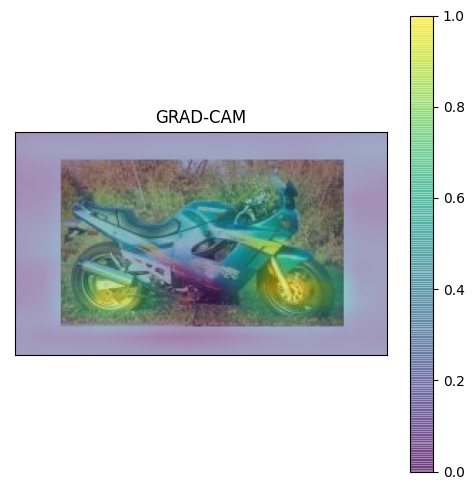

In [91]:
plt.figure(figsize=(5,5))
image_for_plot = np.transpose(image[0].cpu(), (1, 2, 0))
           
plt.imshow(np.array(val_dataset_unchanged[image_index][0]), cmap='gray')
plt.imshow(grad_cam[0].cpu()[0], alpha=.5)
plt.title('GRAD-CAM')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()

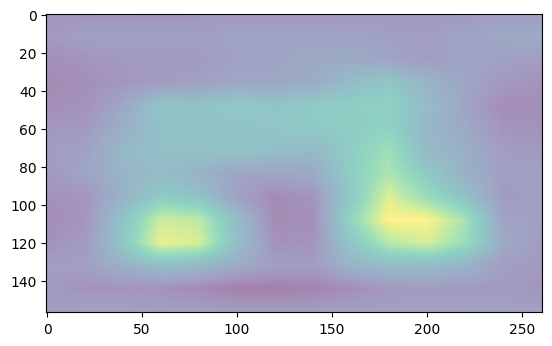

In [92]:
plt.imshow(grad_cam[0].cpu()[0], alpha=.5)

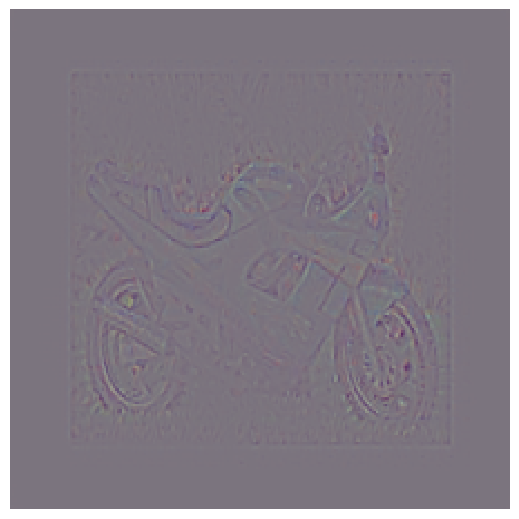

In [93]:
from nn_interpretability.interpretation.backprop.guided_backprop import GuidedBackprop
from nn_interpretability.visualization.rgb_visualizer import RGBVisualizer

img_shape = (image.size(2), image.size(3))
interpretor = GuidedBackprop(model_ft, [], None)
endpoint = interpretor.interpret(image)
RGBVisualizer.show(endpoint, 5, 5)

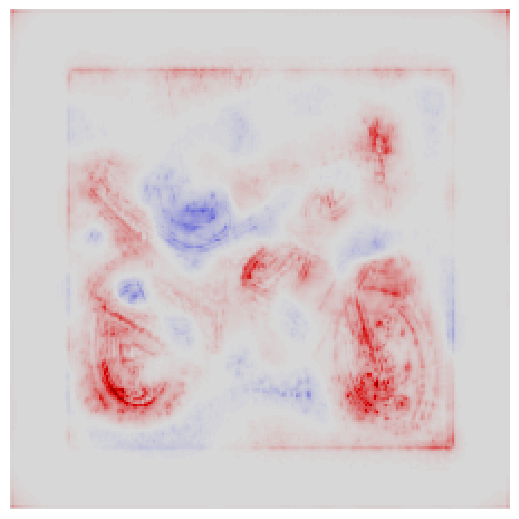

In [94]:
from nn_interpretability.interpretation.lrp.lrp_composite import LRPMix

img_shape = (image.size(2), image.size(3))
interpretor = LRPMix(model_ft, 'predicted', None, 1, 0, 0)
endpoint = interpretor.interpret(image)
RGBVisualizer.heatmap(endpoint[0].detach().cpu().numpy().sum(axis=0), 5, 5)